# North Sea Energy Island: Parametric Revetment Design

In [1]:
# hydraulic conditions RP = 10.000 yrs, DIR = 315 degrees North

h = 27 
Hm0 = 9
Tp = 11.8
N = int(8 * 3600 / Tp)
slope_foreshore = (1, 100)
DHWL = 0.2

# damage levels

Sd = 4
Nod = 3
q = 100

# densities

rho_w = 1025  
rho_rock = 2650
rho_concrete = 2400

<div class="alert alert-block alert-info">

### 2.2 Limit State

Create a limit state with the hydraulic conditions and damage levels.

In [2]:
# create the limit state

import breakwater as bw

battjes = bw.BattjesGroenendijk(
                                Hm0= Hm0, 
                                h= (h + DHWL), 
                                slope_foreshore= slope_foreshore
                                )

H2_per = battjes.get_Hp(0.02)

uls = bw.LimitState(
                    h= (h + DHWL), 
                    H2_per= H2_per, 
                    q= q, 
                    Hm0= Hm0, 
                    Tp= Tp, 
                    Sd= Sd, 
                    Nod= Nod, 
                    label= "uls"
                    )

uls.transform_periods(0.5)

<div class="alert alert-block alert-info">

### 2.3 Material

Create a rock grading and armour units.

In [3]:
# create a rock grading, give correct values for M50, NLL and NUL

def Non_standard_grading(NLL, NUL, rho_s = 2650, A = {'min': 0.663, 'max': 1.515}, 
                         B = {'min': 1.041, 'max': 0.959}, fine = False):
    """
    
    Calculate the M50_emll and the M50_umul for non-standard gradings
    
    Parameters
    -------------
    NLL: int
        Nominal Lower Limit of the grading
    NULL int
        Nominal Upper Limit of the grading
    A: dict
        Coefficient upper and lower
    B: float
        Coefficient upper and lower
        
    returns
    -----------
    tuple
    
    """
    
    if not fine:
        M50 = (NLL + NUL) / 2
        M50_emll = A['min'] * M50 ** B['min']
        M50_umul = A['max'] * M50 ** B['max']
        return (M50_emll, M50_umul)
    
    else:
        NLL = 2650 * (NLL/1000)**3
        NUL = 2650 * (NUL/1000)**3
        M50 = (NLL + NUL) / 2
        M50_emll = A['min'] * M50 ** B['min']
        M50_umul = A['max'] * M50 ** B['max']
        return (NLL, NUL, M50_emll, M50_umul)

# fine gradings
NLL_0_200mm, NUL_0_200mm, M50_emll_0_200mm, M50_umul_0_200mm = Non_standard_grading(NLL = 1, NUL = 200, fine= True)
NLL_0_300mm, NUL_0_300mm, M50_emll_0_300mm, M50_umul_0_300mm = Non_standard_grading(NLL = 1, NUL = 300, fine= True)

# coarse gradings
M50_emll_8_12t, M50_umul_8_12t = Non_standard_grading(NLL = 8000, NUL = 12000)
M50_emll_10_13t, M50_umul_10_13t = Non_standard_grading(NLL = 10000, NUL = 13000)

Grading_EI = {
               '0-200mm':
                   {'M50': [M50_emll_0_200mm, M50_umul_0_200mm], 'NLL': NLL_0_200mm, 'NUL': NLL_0_300mm},
               '0-300mm':
                   {'M50': [M50_emll_0_300mm, M50_umul_0_300mm], 'NLL': NLL_0_300mm, 'NUL': NUL_0_300mm},
               '60-300kg':
                   {'M50': [45, 135], 'NLL': 15, 'NUL': 300},
               '300-1000kg':
                   {'M50': [540, 690], 'NLL': 300, 'NUL': 1000},
               '1-3t':
                   {'M50': [1700, 2100], 'NLL': 1000, 'NUL': 3000},
               '3-6t':
                   {'M50': [4200, 4800], 'NLL': 3000, 'NUL': 6000},
               '8-12t':
                   {'M50': [M50_emll_8_12t, M50_umul_8_12t], 'NLL': 8000, 'NUL': 12000},
               '10-13t':
                   {'M50': [M50_emll_10_13t, M50_umul_10_13t], 'NLL': 10000, 'NUL': 13000}
              }

Grading = bw.RockGrading(grading= Grading_EI)

In [4]:
# Core is quarry run of 1-1000kg

M50_core = (1+1000)/2
Dn50_core = (M50_core / rho_rock)**(1/3)

In [5]:
# create cubipod armour units

def Cubipod_units(masses, rho_c = 2400, n = 1):
    
    """
    Function to create Cubipods from list of masses
    
    Parameters
    -------------
    masses: lst
        list of the masses in tons
    rho_c: int
        density of the concrete in kg/m3
    n: int
        number of layers
    
    returns
    -----------
    dict
    
    """
    
    units = {}
    for m in masses:
        V = m / rho_c * 1000
        Dn = V ** (1/3)
        h = n * Dn
        rho_placement = 100 / (Dn**2 / 0.59)
        Vc = (V * rho_placement) / 100
        V, Dn, h, Vc = round(V, 2), round(Dn, 2), round(h, 2), round(Vc, 2)
        units[V] = {"D": Dn, "h": h, "Vc": Vc, 'M': f'{m}t'}
        
    return units
        
        
        
units = Cubipod_units(masses = [28, 35, 41, 50, 55, 65, 95, 150, 230])


Cubipod = bw.ConcreteArmour(
                            kd=12,
                            name="Cubipods",
                            rho= rho_concrete,
                            units=units,
                            )

Cubipod.units

{11.67: {'D': 2.27, 'h': 2.27, 'Vc': 1.34, 'M': '28t'},
 14.58: {'D': 2.44, 'h': 2.44, 'Vc': 1.44, 'M': '35t'},
 17.08: {'D': 2.58, 'h': 2.58, 'Vc': 1.52, 'M': '41t'},
 20.83: {'D': 2.75, 'h': 2.75, 'Vc': 1.62, 'M': '50t'},
 22.92: {'D': 2.84, 'h': 2.84, 'Vc': 1.68, 'M': '55t'},
 27.08: {'D': 3.0, 'h': 3.0, 'Vc': 1.77, 'M': '65t'},
 39.58: {'D': 3.41, 'h': 3.41, 'Vc': 2.01, 'M': '95t'},
 62.5: {'D': 3.97, 'h': 3.97, 'Vc': 2.34, 'M': '150t'},
 95.83: {'D': 4.58, 'h': 4.58, 'Vc': 2.7, 'M': '230t'}}

<div class="alert alert-block alert-info">

### 2.4 Material procurement

Provide procurement cost voor rock material and armour units.




| Grading | Cost [EUR/t] | Material factor [t/m3] | Cost [EUR/m3]
| --- | --- | --- | ---|
| 0-200mm | 9 | 1.91 | 17.19
| 0-300mm | 9 | 1.91 | 17.19
| 60-300 kg| 12 | 1.85 | 22.20
| QR 1-1000 kg| 11 | 1.80 | 19.80
| 300-1000 kg | 12 | 1.80 | 21.60
| 1-3 t | 12 | 1.80 | 21.60
| 3-6 t | 14 | 1.80 | 25.20
| 8-12 t | 20 | 1.80 | 36.00
| 10-13t | 25 | 1.80 | 45.00
| concrete <100t | 106 | 1.46 | 154.76
| concrete >100t | 127 | 1.46 | 185.42

<div class="alert alert-block alert-info">

### 2.5 Create revetment designs

In [6]:
CRMR = bw.ConcreteRubbleMoundRevetment(
                                        slope= (2,3), 
                                        slope_foreshore= slope_foreshore, 
                                        rho_w= rho_w, 
                                        B= 5, 
                                        N= N,
                                        LimitState= uls, 
                                        Grading= Grading, 
                                        ArmourUnit = Cubipod, 
                                        core_material = {'class': 'QR 1-1000kg', 'Dn50': Dn50_core}, 
                                        filter_rule = 'XblocPlus'
                                      )

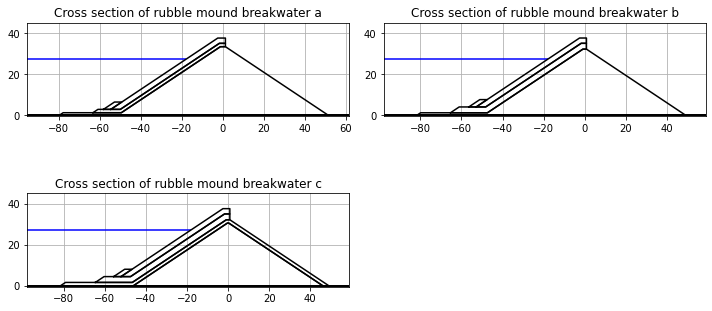

In [7]:
CRMR.plot('all')

In [8]:
CRMR.print_variant('all')

  Variant a
| Layer      |   computed Dn50 | class   |   class Dn50 | state      |   layers | Mass   |
|------------|-----------------|---------|--------------|------------|----------|--------|
| armour     |           2.560 | 17.08   |        2.575 | uls        |        1 | 41t    |
| underlayer |           0.918 | 1-3t    |        0.895 | see armour |        2 |        |
| toe        |           1.062 | 3-6t    |        1.193 | uls        |          |        |

Rc = 10.339 m, designed with uls limit state


  Variant b
| Layer      |   computed Dn50 | class   |   class Dn50 | state      |   layers | Mass   |
|------------|-----------------|---------|--------------|------------|----------|--------|
| armour     |           2.560 | 17.08   |        2.575 | uls        |        1 | 41t    |
| underlayer |           1.246 | 8-12t   |        1.558 | see armour |        2 |        |
| toe        |           1.062 | 3-6t    |        1.193 | uls        |          |        |

Rc = 10.339 m, de

<div class="alert alert-block alert-info">

## 3. Expanded python-based parametric design

The current Python tool allows the user only to optimize a design based on the procurement cost of material. The procurement cost is only a fraction of the total cost of the structure. Transport of the material and the installation also take a big part in this cost estimation. Besides optimization in terms of cost it would give also insights if optimization in installation duration is possible. Moreover, the extraction, processing and handling of primary aggregatis is responsible for 7% of global energy consumption. Therefore a design which reduces the $CO_2$ emission is also favourable. The expanded tool will therefore also allow the user to optimize the design on:


1. $CO_2$ emission of the material
2. Cost of installation methods
3. $CO_2$ emission of the installation methods

<div class="alert alert-block alert-info">

### 3.1 $CO_2$ emission of the material

This emission is only related to the production of the material. Transport or other sources of CO2 emission are not taken into account here. The values of CO2 emission are given in kg$CO_2$e/t or kilograms of carbon dioxide equivalent per ton. This is a quantity that describes the amount of CO2 that would have the same global warming potential (GWP), when measured over a specified timescale (generally, 100 years).

| Grading | Cost [kg$CO_2$e/t] | Material factor [t/m3] | Cost [kg$CO_2$e/m3]
| --- | --- | --- | ---|
| 0-200mm | $5\cdot10^{-6}$ | 1.91 | $9.55\cdot10^{-6}$
| 0-300mm | $5\cdot10^{-6}$ | 1.91 | $9.55\cdot10^{-6}$
| 60-300 kg| $5\cdot10^{-6}$ | 1.85 | $9.25\cdot10^{-6}$
| QR 1-1000 kg| $5\cdot10^{-6}$| 1.80 | $9\cdot10^{-6}$
| 300-1000 kg| $2\cdot10^{-5}$ | 1.80 | $3.6\cdot10^{-5}$
| 1-3 t | $2\cdot10^{-5}$ | 1.80 | $3.6 \cdot 10^{-5}$
| 3-6 t | $2\cdot10^{-5}$ | 1.80 | $3.6 \cdot 10^{-5}$
| 8-12 t | $2\cdot10^{-5}$ | 1.80 | $3.6 \cdot 10^{-5}$
| 1-13t | $2\cdot10^{-5}$ | 1.80 | $3.6 \cdot 10^{-5}$
| concrete <100t | $1\cdot10^{-4}$ | 1.46 | $1.46\cdot10^{-4}$
| concrete >100t | $1\cdot10^{-4}$| 1.46 |$1.46\cdot10^{-4}$

In [9]:
rock_procurement = {
                     '0-200mm': {'cost': 9, 'CO2': 9.55*10**-6}, 
                     '0-300mm': {'cost': 9, 'CO2': 9.55*10**-6}, 
                     '60-300kg': {'cost': 12, 'CO2': 9.25*10**-6}, 
                     '300-1000kg': {'cost': 12, 'CO2': 3.6*10**-5}, 
                     '1-3t': {'cost': 12, 'CO2': 3.6*10**-5}, 
                     '3-6t': {'cost': 14, 'CO2': 3.6*10**-5}, 
                     '8-12t': {'cost': 20, 'CO2': 3.6*10**-5}, 
                     '10-13t': {'cost': 25, 'CO2': 3.6*10**-5}
                    }


Cubipod_procurement = {
                        11.67: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        14.58: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        17.08: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        20.83: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        22.92: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        27.08: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        39.58: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        62.5: {'cost': 105.51 + 20.83, 'CO2': 1.46*10**-4},
                        95.83: {'cost': 105.51 + 20.83, 'CO2': 1.46*10**-4},
                        }

Grading.add_cost(rock_procurement)

<div class="alert alert-block alert-info">

### 3.2 Cost of installation methods

The introduction of the installation methods provides a more accurate estimate of the structure costs. Below is a list of the equipment used for Energy Island.

1. Land based equipment

    a. Caterpillar 345 $\newline$
    b. Caterpillar 385 $\newline$
    c. Hitachi 1200 $\newline$
    d. Hitachi 1900 $\newline$
    e. Liebherr 300t $\newline$
    
2. Marine based equipment

    a. Fall pipe vessel Storness $\newline$
    b. Fall pipe vessel Braveness $\newline$
    c. Side stone dumper HAM602 $\newline$
    d. Side stone dumper Resolution $\newline$
    e. Stoney-3 barge

In [10]:
# Water levels LAT

MHW = 27 + 0.51 
MSL = 27 + 0.32
MLW = 27 + 0.17

<div class="alert alert-block alert-info">

#### 3.2.1 Land based equipment

Below is demonstrated how the land based equipment is created.

In [11]:
# platefeeder

platefeeder = bw.PlateFeeder(name = 'platefeeder',
                             design_type = {'0-200mm': {'cost': 69, 'CO2': None, 'production_rate': 18332.86},
                                            '0-300mm': {'cost': 46, 'CO2': None, 'production_rate':  35984.79},
                                            'QR 1-1000kg': {'cost': 30, 'CO2': None, 'production_rate':  23648.19},
                                           '60-300kg': {'cost': 57, 'CO2': None, 'production_rate':  21343.11},
                                           '300-1000kg': {'cost': 57, 'CO2': None, 'production_rate':  21343.11},
                                           },
                             waterlvl = MHW,
                             h_dry = 2,
                             top_installation = 4,
)


In [12]:
# dumptruck

dumptruck = bw.Truck(name = 'dumptruck',
                     design_type = {'0-300mm': {'cost': 16, 'CO2': None, 'production_rate':  15713.88},
                                    'QR 1-1000kg': {'cost': 16, 'CO2': None, 'production_rate':  16197.39}},
                     waterlvl = MHW,
                     h_dry = 2,
)

In [13]:
# Caterpillar 385 -> define manually

loading_chart_385 = {
    12: {
        'x': [10.5], 
        'w': [4.64]
        },
    10.5: {
        'x': [10.5], 
        'w': [8.3]
        },
    9: {
        'x': [10.5, 12.0], 
        'w': [9.51, 6.89]
        },
    7.5: {
        'x': [10.5, 12.0], 
        'w': [10.59, 8.91]
        },
    6.0: {
        'x': [9, 10.5, 12, 13.5], 
        'w': [12.78, 11.91, 8.88, 5.29]
        },
    4.5: {
        'x': [7.5, 9, 10.5, 12.0, 13.5], 
        'w': [18.94, 15.42, 11.45, 8.61, 6.42]
        },
    3.0: {
        'x': [6, 7.5, 9, 10.5, 12.0, 13.5], 
        'w': [28.12, 20.05, 14.59, 10.93, 8.29, 6.26]
        },
    1.5: {
        'x': [6, 7.5, 9, 10.5, 12.0, 13.5], 
        'w': [26.99, 18.78, 13.80, 10.42, 7.97, 6.08]
        },
    0: {
        'x': [4.5, 6, 7.5, 9, 10.5, 12, 13.5], 
        'w': [13.81, 25.5, 17.79, 13.14, 9.98, 7.69, 5.93]
        },
    -1.5: {
        'x': [3, 4.5, 6, 7.5, 9, 10.5, 12], 
        'w': [8.97, 17.21, 24.67, 17.13, 12.66, 9.66, 7.49]
        },
    -3: {
        'x': [1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12], 
        'w': [10.73, 14.18, 22.53, 24.32, 16.79, 12.39, 9.47, 7.4]
        },
    -4.5: {
        'x': [1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12], 
        'w': [15.97, 20.26, 29.75, 24.35, 16.72, 12.32, 9.45, 7.49]
        },
    -6: {
        'x': [3, 4.5, 6, 7.5, 9, 10.5], 
        'w': [27.75, 35.92, 24.71, 16.93, 12.49, 96.70]
        },
    -7.5: {
        'x': [3, 4.5, 6, 7.5, 9], 
        'w': [36.87, 28.09, 22.05, 17.14, 12.41]
        }
}

CP385 = bw.Excavator(
    name = 'CP385',
     loading_chart = loading_chart_385,
     design_type = {'60-300kg': {'cost': 39, 'CO2': None, 'production_rate': 14761.90},
                    '300-1000kg': {'cost': 39, 'CO2': None, 'production_rate':  14761.90},
                     '1-3t': {'cost': 61, 'CO2': None, 'production_rate':  3899.37}},
     waterlvl = MHW,
     h_dry = 2,
)


In [14]:
# Hitachi excavators -> already defined in breakwater package

Hit1200 = bw.HITACHI_EX1200(name = 'Hit1200',
                            design_type = {'3-6t': {'cost': 56, 'CO2': None, 'production_rate':  6963.16}},
                            waterlvl = MHW,
                            h_dry = 2,
)


Hit1900 = bw.HITACHI_EX1900(name = 'Hit1900',
                            design_type = {'1-3t': {'cost': 56, 'CO2': None, 'production_rate':  6963.16},
                                           '3-6t': {'cost': 56, 'CO2': None, 'production_rate':  6963.16},
                                           '8-12t': {'cost': 57, 'CO2': None, 'production_rate':  8355.80},
                                           '10-13t': {'cost': 57, 'CO2': None, 'production_rate':  7687.33},
                                           '28t': {'cost': 57, 'CO2': None, 'production_rate': 14043.08}},
                            waterlvl = MHW,
                            h_dry = 2,
)

In [15]:
# read Liebherr 300 ton csv file

import pandas as pd

lc_300 = pd.read_csv('Liebherr300t.csv')
lc_300 = lc_300.set_index('Radius')

Liebherr300 = bw.Crane(name= 'Liebherr300',
                       design_type= {'28t': {'cost': 174, 'CO2': None, 'production_rate': 4110.17},
                                     '55t': {'cost': 159, 'CO2': None, 'production_rate': 4452.68},
                                     '41t': {'cost': 145, 'CO2': None, 'production_rate': 4795.20},
                                     '50t': {'cost': 137, 'CO2': None, 'production_rate': 5137.71},
                                     '55t': {'cost': 130, 'CO2': None, 'production_rate': 5822.74},
                                     '65t': {'cost': 115, 'CO2': None, 'production_rate': 6679.03},
                                     '95t': {'cost': 108, 'CO2': None, 'production_rate': 6850.28},
                                     '150t': {'cost': 92, 'CO2': None, 'production_rate': 8562.85},
                                     '230t': {'cost': 85, 'CO2': None, 'production_rate': 9932.91}},
                       loading_chart = lc_300,
                       waterlvl= MHW,
                       h_dry= 2
                            )


lc_700 = pd.read_csv('Liebherr700t.csv')
lc_700 = lc_700.set_index('Radius')

Liebherr700 = bw.Crane(name= 'Liebherr700',
                       design_type= {'28t': {'cost': 204, 'CO2': None, 'production_rate': 3110.17},
                                     '55t': {'cost': 189, 'CO2': None, 'production_rate': 3452.68},
                                     '41t': {'cost': 175, 'CO2': None, 'production_rate': 3795.20},
                                     '50t': {'cost': 167, 'CO2': None, 'production_rate': 4137.71},
                                     '55t': {'cost': 160, 'CO2': None, 'production_rate': 4822.74},
                                     '65t': {'cost': 145, 'CO2': None, 'production_rate': 5679.03},
                                     '95t': {'cost': 138, 'CO2': None, 'production_rate': 5850.28},
                                     '150t': {'cost': 122, 'CO2': None, 'production_rate': 7562.85},
                                     '230t': {'cost': 115, 'CO2': None, 'production_rate': 8932.91}},
                       loading_chart = lc_700,
                       waterlvl= MHW,
                       h_dry= 2
                            )


<div class="alert alert-block alert-info">

#### 3.2.2 Marine based equipment

Below is demonstrated how the marine based equipment is created.

In [16]:
# fallpipe vessels

FFPV_stor = bw.Vessel(name = 'FFPV_storness',
                      design_type = {'0-200mm': {'cost': 40, 'CO2': None, 'production_rate': 22261.33}},
                      waterlvl = MLW,
                      installation_waterdepth = 14,
)

FFPV_brave = bw.Vessel(name = 'FFPV_braveness',
                       design_type = {'0-200mm': {'cost': 40, 'CO2': None, 'production_rate': 22261.33},
                                    '0-300mm': {'cost': 32, 'CO2': None, 'production_rate': 24618.42},
                                    '60-300kg': {'cost': 42, 'CO2': None, 'production_rate': 18240.51}},
                       waterlvl = MLW,
                       installation_waterdepth = 8,
)

In [17]:
# side stone dumper

SSD_res = bw.Vessel(name = 'SSD_resolution',
                    design_type = {'0-200mm': {'cost': 59, 'CO2': None, 'production_rate': 14928.19},
                                   '0-300mm': {'cost': 55, 'CO2': None, 'production_rate': 15504.36},
                                   'QR 1-1000kg': {'cost': 57, 'CO2': None, 'production_rate': 14793.61},
                                   '60-300kg': {'cost': 58, 'CO2': None, 'production_rate': 14483.83},
                                   '300-1000kg': {'cost': 58, 'CO2': None, 'production_rate': 14483.83},
                                   '1-3t': {'cost': 74, 'CO2': None, 'production_rate': 1141.06},
                                   '3-6t': {'cost': 79, 'CO2': None, 'production_rate': 10528.30},
                                   '8-12t': {'cost': 65, 'CO2': None, 'production_rate': 13090.75},
                                   '10-13t': {'cost': 65, 'CO2': None, 'production_rate': 13202.16}},
                    waterlvl = MLW,
                    installation_waterdepth = 5,
)

SSD_HAM = bw.Vessel(name = 'SSD_HAM602',
                    design_type = {'QR 1-1000kg': {'cost': 100, 'CO2': None, 'production_rate': 1889.70},
                                   '300-1000kg': {'cost': 86, 'CO2': None, 'production_rate': 2228.21}},
                    waterlvl = MLW,
                    installation_waterdepth = 3,
)


In [18]:
# barge with Hit1900

barge_Hit1900 = bw.Barge(name = 'Barge_Hit1900',
                         waterlvl = MLW,
                         other = Hit1900,
                         downtime_production = 100,
                         extra_cost = 500,
                         installation_waterdepth = 4.4,
                         height = 7
)

barge_Liebherr300 = bw.Barge(name = 'Barge_Liebherr300',
                         waterlvl = MLW,
                         other = Liebherr300,
                         downtime_production = 100,
                         extra_cost = 500,
                         installation_waterdepth = 4.4,
                         height = 7
)

barge_Liebherr700 = bw.Barge(name = 'Barge_Liebherr700',
                         waterlvl = MLW,
                         other = Liebherr700,
                         downtime_production = 100,
                         extra_cost = 500,
                         installation_waterdepth = 4.4,
                         height = 7
)


barge_platefeeder = bw.Barge(name = 'Barge_platefeeder',
                         waterlvl = MLW,
                         other = platefeeder,
                         downtime_production = 100,
                         extra_cost = 500,
                         installation_waterdepth = 4.4,
                         height = 7
)

In [19]:
all_equipment = [dumptruck, CP385, Hit1200, Hit1900, Liebherr300, Liebherr700,
                 FFPV_stor, FFPV_brave, SSD_res, SSD_HAM, barge_Hit1900, 
                 barge_Liebherr300, barge_Liebherr700,  barge_platefeeder]


<div class="alert alert-block alert-info">

#### 3.2.2 Cheap Combinations

In [20]:
%%time

total_cost, material_CO2, duration, opt_equip = CRMR.total_cost('all',
                                                                equipment = all_equipment,
                                                                core_price = {'cost': 11, 'CO2': 9*10**-6},
                                                                unit_price = Cubipod_procurement,
                                                                optimize_on = ['cost', 'time'],
                                                                algorithm = 'cheap_combinations')

Wall time: 2.85 s


In [21]:
total_cost

{'a': 271492.33, 'b': 253071.55, 'c': 228284.34}

In [22]:
material_CO2

{'a': 0.0447, 'b': 0.0457, 'c': 0.0519}

In [23]:
duration

{'a': 0.2515, 'b': 0.19088, 'c': 0.21676}

In [24]:
opt_equip

{'a': 'Barge_Liebherr300 + Liebherr700 + Liebherr300 + SSD_resolution + Hit1900 + CP385 + SSD_HAM602 + Barge_platefeeder + dumptruck',
 'b': 'Barge_Liebherr300 + Liebherr700 + Liebherr300 + SSD_resolution + Hit1900 + SSD_HAM602 + Barge_platefeeder + dumptruck',
 'c': 'Barge_Liebherr300 + Liebherr700 + Liebherr300 + SSD_resolution + Hit1900 + SSD_HAM602 + Barge_platefeeder + dumptruck'}

<div class="alert alert-block alert-info">

#### 3.2.2 Cheap Combinations with threshold

In [25]:
%%time

total_cost, material_CO2, duration, opt_equip = CRMR.total_cost('all',
                                                                equipment = all_equipment,
                                                                core_price = {'cost': 11, 'CO2': 9*10**-6},
                                                                unit_price = Cubipod_procurement,
                                                                optimize_on = ['cost', 'time'],
                                                                algorithm = 'cheap_combinations',
                                                                threshold = 6)

Wall time: 3.07 s


In [26]:
total_cost

{'a': 285546.77, 'b': 259690.91, 'c': 229909.58}

In [27]:
material_CO2

{'a': 0.0447, 'b': 0.0457, 'c': 0.0519}

In [28]:
duration

{'a': 0.25336, 'b': 0.19296, 'c': 0.21902}

In [29]:
opt_equip

{'a': 'Barge_Liebherr300 + Liebherr700 + SSD_resolution + Hit1900 + SSD_HAM602 + Barge_platefeeder',
 'b': 'Barge_Liebherr300 + Liebherr700 + SSD_resolution + Hit1900 + SSD_HAM602 + Barge_platefeeder',
 'c': 'Barge_Liebherr300 + Liebherr700 + SSD_resolution + Hit1900 + SSD_HAM602 + Barge_platefeeder'}

<div class="alert alert-block alert-info">

#### 3.2.2 Smart Combinations

In [30]:
%%time

total_cost, material_CO2, duration, opt_equip = CRMR.total_cost('all',
                                                                equipment = all_equipment,
                                                                core_price = {'cost': 11, 'CO2': 9*10**-6},
                                                                unit_price = Cubipod_procurement,
                                                                optimize_on = ['cost', 'time'],
                                                                algorithm = 'smart_combinations')

Wall time: 2.79 s


In [31]:
total_cost

{'a': 300266.98, 'b': 278102.81, 'c': 248264.6}

In [32]:
material_CO2

{'a': 0.0447, 'b': 0.0457, 'c': 0.0519}

In [33]:
duration

{'a': 0.21893, 'b': 0.16255, 'c': 0.19414}

In [34]:
opt_equip

{'a': 'Liebherr300 + Hit1900 + Liebherr700 + dumptruck + SSD_resolution + Barge_Liebherr300 + Barge_platefeeder',
 'b': 'Liebherr300 + Hit1900 + Liebherr700 + dumptruck + SSD_resolution + Barge_Liebherr300 + Barge_platefeeder',
 'c': 'Liebherr300 + Hit1900 + Liebherr700 + dumptruck + SSD_resolution + Barge_Liebherr300 + Barge_platefeeder'}